In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Changes

Changes:

new ant mapper : nsvf_map.txt

# [ IMPORTS ]

In [1]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.signal as scsig

# [ GLOBAL ]

In [2]:
#===========================================================================================================
# DEFINE SOURCE DIRECTORIES
#===========================================================================================================
# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data' #'/home/spooky/ecg/workdir'
print('GLOBAL DIR :: '+global_dir)

#===========================================================================================================
#  following are required for one time npy database building

# >> global MAT directory, contains signal data in matlab (.mat) format
global_matdir = os.path.join(global_dir, 'db_mat') 
print('GLOBAL MAT DIR :: '+global_matdir)

# >> global NPY directory, contains signal and meta data in numpy (.npy) format
global_npydir = os.path.join(global_dir, 'db_npy') 
print('GLOBAL NPY DIR :: '+global_npydir)

# beat and non-beat annotations, signal data types to be used to save data in npy format
g_BEAT_POSTFIX = 'BEAT'         #<<--- beat annotations
g_NBEAT_POSTFIX = 'NBEAT'       #<<--- non-beat annotations
g_RAW_II_POSTFIX = 'RAW_II'     #<<--- Raw lead2 signal from mat file
g_BLF_II_POSTFIX = 'BLF_II'     #<<--- Baseline fitted signal
g_RES_II_POSTFIX = 'RES_II'     #<<--- Resampled to BASIC_SRATE
g_SIG_II_POSTFIX = 'SIG_II'     #<<--- Removed manual gain
#===========================================================================================================

#=================================================
# Auto-Create other working directory
#=================================================
# >> model directory, contains model weights, use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model')
print('GLOBAL MODEL DIR :: ' + global_modeldir)

# >> dataset directory, contains manually generated datasets to be used for experiment
global_dsdir = os.path.join(global_dir, 'db_dataset') 
print('GLOBAL DATASET DIR :: ' + global_dsdir)

# >> temp directory, contains manually generated temporary data to be used for experiments
global_tempdir = os.path.join(global_dir, 'db_temp') 
print('GLOBAL TEMP DIR :: ' + global_tempdir)
#>>----------------------------------------------- 

# >> annotation directory, contains annotation mapping files to be used for experiments
global_antdir = os.path.join(global_dir, 'db_ant') 
print('GLOBAL ANNOTATION DIR :: ' + global_antdir)
#>>----------------------------------------------- 

# Resample every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))

GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL DATASET DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL TEMP DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp
GLOBAL ANNOTATION DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant
Basic sampling rate(Hz): 128


# [ CLASS_DEFS ]

In [3]:
#Class Definitions
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  exclude_recs, tag_recs, sampling_rate):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #float or int
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_npy,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_recs)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.recs_tag = set(tag_recs)
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'SAMPLING RATE :: '+ str(self.srate))
        print( 'DATA DIR :: ' + self.dir_npy )
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self, recset):
        rec = random.choice(list(recset))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
g_SUPRESS_DATA_WARNING=False
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name
        if recname in db.recs_all:
            if recname in db.recs_exc:
                print('WARNING:: Record "'+ recname +'" is marked excluded from database '+ db.name )
        else:
            print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )
        self.data_npy = {}                          # dict dict of data file content used in self.read_data_npy('key')
        self.data_temp = {}                          # dict dict of data file content used in self.read_data_temp('key')
        self.binfo = None                           # class binfo       

##<------------------------------------------------- get instance of binfo class
    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo

    def refresh_binfo(self):
        self.binfo = ecg_binfo(self)
        return self.binfo

##<------------------------------------------------- data reading for npydir
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_npy[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data(self, data_type):
        if data_type in self.data_npy.keys():
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

##<------------------------------------------------- for tempdir
    def load_data_temp(self, data_type, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_temp[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data_temp(self, data_type, dir_path):
        if data_type in self.data_temp.keys():
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data_temp(data_type, dir_path)

    def save_data_temp(self, data_type, data_array, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def del_data_temp(self, data_type, dir_path, vb):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            if vb:
                print('Removing: '+str(ipath))
            os.remove(ipath)
            return 1
        else:
            return 0
#------------------------------------------------------------------------------------------------

class ecg_binfo:
    def __init__(self, rec):
         
        # the record object
        self.rec = rec
        
        # calulate ratio for converting peak locations to basic_sampling_rate
        self.sr_ratio = BASIC_SRATE/self.rec.db.srate
        
        # read orignal annotations
        r_peaks_ants = rec.read_data(g_BEAT_POSTFIX)       # orignal ant file [ *  '625310' 'N' * ] 
        
        # calculate count of R peaks (excluding first and last)
        self.rp_count = len(r_peaks_ants) - 2
        
        # Extract Location and Labels of Peaks (exclude first and last beat)
        r_peaks_int_raw = r_peaks_ants[:,0].astype('int')
        r_peaks_int = np.round(r_peaks_int_raw * self.sr_ratio).astype('int')
        r_ants_str = r_peaks_ants[:,1]
        
        # Location
        self.rp_raw = r_peaks_int_raw[1:-1]
        self.rp_curr = r_peaks_int[1:-1]    # current R peak
        self.rp_prev = r_peaks_int[0:-2]    # previous R peak (in samples)
        self.rp_next = r_peaks_int[2:]      # next R peak (in samples)
        
        # Label
        self.rl_curr = r_ants_str[1:-1]
        self.rl_prev = r_ants_str[0:-2]
        self.rl_next = r_ants_str[2:]
 
        # calculate temporal info
        self.rp_sec = self.rp_curr / BASIC_SRATE                 # peak location (in sec)
        self.rri_prev = (self.rp_curr - self.rp_prev) / BASIC_SRATE   # prev RRI (in sec) 
        self.rri_next = (self.rp_next - self.rp_curr) / BASIC_SRATE   # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)              # difference b/w prev and next RRI (in sec) 
        self.rri_dur = (self.rri_next + self.rri_prev)                # total duration from prev to next R-peak
        

    def get_signal_data_var(self, ith_peak): # data_type = g_SIG_II_POSTFIX
        # prev peak to next peak
        sel_sig = self.rec.read_data(g_SIG_II_POSTFIX) 
        ff = self.rp_prev[ith_peak]
        tt = self.rp_next[ith_peak]
        pp = self.rp_curr[ith_peak]
        return sel_sig[ff:tt+1], (pp-ff) #<- also return position of peak
    
    def get_signal_data_fix(self, ith_peak, v_left_sec, v_right_sec): # data_type = g_SIG_II_POSTFIX
        sel_sig = self.rec.read_data(g_SIG_II_POSTFIX) 
        ff = self.rp_curr[ith_peak]-int(v_left_sec*BASIC_SRATE)
        tt = self.rp_curr[ith_peak]+int(v_right_sec*BASIC_SRATE)
        pp = self.rp_curr[ith_peak]
        return sel_sig[ff:tt+1], (pp-ff) #<- also return position of peak
    
    def map_ants2int(self,map_function):
         self.rli_curr = map_function(self.rl_curr)
         self.rli_prev = map_function(self.rl_prev)
         self.rli_next = map_function(self.rl_next)
#-----------------------------------------------------------------------------------------------


# [ SELECT ANT MAPPER ] 

In [ ]:
ls_ants = os.listdir(global_antdir)
print('Available annotation files ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

Available annotation files [4]
default_map.txt
default_labels.txt
nsvf_map.txt
nsvf_labels.txt
--------------------------


## [ *mapping_labels* ]

In [4]:
# standard labels and mappings
sel_labels = os.path.join(global_antdir, 'nsvf_labels.txt') 
sel_map = os.path.join(global_antdir, 'nsvf_map.txt') 

# ------ load standard labels ------------------------------------------
sel_labels_data = np.loadtxt(sel_labels, dtype='str',delimiter="\t")
g_STD_LABELS={}
print('\nStandard Labels::')
for a in sel_labels_data:
    # a[0] =  # standard label (char)
    # a[1] =  # mapped color (str)
    # a[2]  = # description (str)
    g_STD_LABELS[a[0]]= a[1]
    print(a[0]+'\t'+a[1]+'\t'+a[2])
#g_LABELS = np.array(list(g_STD_LABELS.keys()))
# ------ load mapping data ------------------------------------------
ant_map_data = np.loadtxt(sel_map, dtype='str',delimiter="\t")
g_STD_NO_MAP = '_'
g_STD_MAP={}
print('\nMapping::')
for a in ant_map_data:
    # a[0] =  # orignal pysionet label (char)
    # a[1] =  # mapped standard label (char)
    # a[2]  = # description (str)
    g_STD_MAP[a[0]]= a[1] ##<<----------------mapping dictionary
    print(a[0]+'\t'+a[1]+'\t'+a[2])
print('\n',g_STD_MAP.keys())

# define array mapping function --------------------------------------
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='str')     # should be single char
    for i in range(0, len(peak_label)):
        res[i] = g_STD_MAP[peak_label[i]]
    return res

#g_LABELS = g_LABELS_MAP[:,0]
#g_COLOR = g_LABELS_MAP[:,1]
# T10 categorical palette
# ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
# 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
# 'tab:olive', 'tab:cyan']
#print(len(g_LABELS_MAP))
#print(g_LABELS_MAP)




Standard Labels::
N	green	Normal
S	red	Supraventricular Premature
V	blue	Ventricular Premature
F	brown	Fusion

Mapping::
N	N	Normal beat
L	N	Left bundle branch block beat
R	N	Right bundle branch block beat
B	N	Bundle branch block beat (unspecified)
A	S	Atrial premature beat
a	S	Aberrated atrial premature beat
J	S	Nodal (junctional) premature beat
S	S	Supraventricular premature or ectopic beat (atrial or nodal)
V	V	Premature ventricular contraction
r	V	R-on-T premature ventricular contraction
F	F	Fusion of ventricular and normal beat
e	_	Atrial escape beat
j	_	Nodal (junctional) escape beat
n	_	Supraventricular escape beat (atrial or nodal)
E	_	Ventricular escape beat
/	_	Paced beat
f	_	Fusion of paced and normal beat
Q	_	Unclassifiable 
?	_	Beat not classified during learning
[	_	Start of ventricular flutter/fibrillation
!	_	Ventricular flutter wave
]	_	End of ventricular flutter/fibrillation
x	_	Non-conducted P-wave (blocked APC)
(	_	Waveform onset
)	_	Waveform end
p	_	Peak of P-wave

# [ MODEL ]

input is fixed length  = S sec = S*BASIC_SRATE samples

from each record, select S sec intervals (with overlapping) - label each sampleing point [0=nolabel; 1=S; 2=V; 3=F]

Let - 
signal segment length = S (sec);
segment increment = I (sec);
Total signal Length = L (sec)

Sequence = [0I,0I+S], [1I, 1I+S], [2I, 2I+S].....[KI, KI+S]

KI+S = L;
K = (L-S)/I

K(L=1800, S=30, I=10) = (1800-30)/10 = 177

## [ input-output params ]

In [5]:
#------------------------------------------------- input shape params
pr_L = 1800 # total signal length
pr_S = 30   # signal segment length
pr_I = 10   # segment increment length
pr_K = int((pr_L-pr_S)/pr_I) # loop 0 to pr_K

#------------------------------------------------- convert sec->samples
L = pr_L * BASIC_SRATE
S = pr_S * BASIC_SRATE          #<<--------------- this is the input-output length
I = pr_I * BASIC_SRATE

## [ Model Def ]

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, UpSampling1D, Concatenate
from tensorflow.keras.models import Model, Sequential
from keras.utils import to_categorical

## [ Unet_model ]

In [84]:
def down_block(x, filters, kernel_size=3, padding="same", strides=1):
    c = Conv1D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv1D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPooling1D(pool_size=2)(c)
    return c, p

def up_block(x, skip, filters, kernel_size=3, padding="same", strides=1):
    us = UpSampling1D(size=2)(x)
    concat = Concatenate()([us, skip])
    c = Conv1D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv1D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=3, padding="same", strides=1):
    c = Conv1D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv1D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    iLayer = Input(shape=(S, 1))
    
    p0 = iLayer
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    oLayer = Conv1D(4, 1, padding="same", activation="sigmoid")(u4)
    model = Model(iLayer, oLayer)
    return model

In [85]:
model = UNet()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()



Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 3840, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_303 (Conv1D)             (None, 3840, 16)     64          input_24[0][0]                   
__________________________________________________________________________________________________
conv1d_304 (Conv1D)             (None, 3840, 16)     784         conv1d_303[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_92 (MaxPooling1D) (None, 1920, 16)     0           conv1d_304[0][0]                 
____________________________________________________________________________________________

In [67]:
#<<----------------------------------------------- Get model and Data
data_x = np.expand_dims(mega_set[:,0:S],axis=-1)
dy = mega_set[:,S:]

print(data_x.shape,data_y.shape)

(178, 3840, 1) (178, 3840)


In [82]:
data_y = np.zeros((0,dy.shape[1],4))
for i in range(0,dy.shape[0]):
    d1 = np.zeros((0,4))
    for j in range(0, dy.shape[1]):
        suba = np.zeros(4)
        suba[int(dy[i][j])]=1
        d1 = np.vstack((d1,suba))
    #print(d1.shape)
    d1 = np.expand_dims(d1,axis=0)
    #print(d1.shape)
    data_y = np.vstack((data_y,d1))
print(data_x.shape,data_y.shape)



(178, 3840, 1) (178, 3840, 4)


[1. 1. 1. ... 1. 1. 1.]


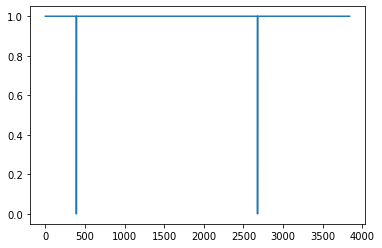

In [108]:
res1 = data_y[5,:,0]
print(res1)
plt.plot(res1)

## [ ecg_model ]

In [ ]:
cost = 'sparse_categorical_crossentropy'
opt = 'rmsprop'
#-----------------------------------------------------------------------------------------
def get_modelFullCNN(print_summary):
    iLayer = Input( shape=(S,1), name = "input_layer" )

    conv1 = Conv1D       (32,                               #filters, 
                          3,                                #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv1') (iLayer) 

    conv2 = Conv1D       (32,                               #filters, 
                          3,                                #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv2') (conv1) 

    conv3 = Conv1D       (64,                               #filters, 
                          3,                                #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv3') (conv2) 

    conv4 = Conv1D       (64,                               #filters, 
                          3,                                #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv4') (conv3) 

    flat5 = Flatten(data_format=None, name='flat5') (conv4)

    dense6 = Dense(128, activation=tf.nn.relu, name = "dense6") (flat5)  

    dense7 = Dense(64, activation=tf.nn.relu, name = "dense7") (dense6) 

    oLayer = Dense(S, activation=tf.nn.softmax, name = "output_layer")(dense7)


    model=Model(inputs=iLayer, outputs=oLayer)
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])

    if print_summary:
        print(model.summary())
    return model
#-----------------------------------------------------------------------------------------

# call back
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', 
        min_delta=0.00001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 

# [ TRAINING ]

## [ Training DB ]

In [52]:
print('Buidling train_db1')
train_db1 = {}
#------------------------------------------------------------------------
mitdb_ex = []
mitdb_tags = ['210']
train_db1['mitdb'] = ecg_db('mitdb',  mitdb_ex, mitdb_tags, 360)
#------------------------------------------------------------------------
svdb_ex = []
svdb_tags = []
train_db1['svdb'] = ecg_db('svdb',  svdb_ex, svdb_tags, 128)
#------------------------------------------------------------------------
incartdb_ex = []
incartdb_tags = []
train_db1['incartdb'] = ecg_db('incartdb', incartdb_ex, incartdb_tags, 257)
#------------------------------------------------------------------------
print('')
print(train_db1.keys())


Buidling train_db1

Initailze new ecg database ... 
DB NAME :: mitdb
SAMPLING RATE :: 360
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
RECORD SET :: [48] {'105', '106', '101', '214', '107', '113', '123', '223', '124', '116', '118', '103', '208', '100', '232', '219', '203', '202', '233', '231', '217', '205', '119', '102', '112', '213', '121', '115', '210', '209', '108', '111', '215', '122', '201', '109', '220', '234', '104', '230', '117', '200', '221', '222', '228', '114', '212', '207'}

Initailze new ecg database ... 
DB NAME :: svdb
SAMPLING RATE :: 128
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
RECORD SET :: [78] {'811', '884', '806', '858', '859', '865', '876', '809', '800', '825', '829', '889', '845', '872', '880', '842', '877', '826', '879', '802', '857', '801', '871', '882', '827', '822', '820', '888', '868', '851', '881', '807', '885', '812', '853', '850', '821', '808', '892', '864', '860', '890', '824', '841', '

## [ prepare data ]

In [ ]:
#------------------------------------------------- Set Params
training_set_name = 'train_set_1'
save_path = os.path.join(global_dsdir, training_set_name+'.npy')
train_db = train_db1

#-------------------------------------------------
timestamp_start = datetime.datetime.now()
mega_set = np.zeros((0,S*2),dtype='float')
for idb in train_db:
    sel_db = train_db[idb]
    for irec in sel_db.recs_tag:
        sel_rec = sel_db.get_record(irec)
        print(sel_rec.name)

        # load signal data
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        if len(sel_sig)==0:
            continue

        # load signal meta data
        sbi = sel_rec.read_binfo()
        sbi.map_ants2int(mapstd)


        # initialize loop 
        for i in range(0,pr_K+1):
            fs = i*I
            ts = i*I + S

            # extract signal
            sig_seg = sel_sig[fs:ts]

            # prepare labels
            sig_lab = np.zeros(len(sig_seg),dtype = 'float')

            # read query
            np_query = (sbi.rp_curr>=fs) & (sbi.rp_curr<ts)
            np_indx = np.where(np_query)[0]

            np_rpeaks = sbi.rp_curr[np_indx] - fs
            np_labels = sbi.rli_curr[np_indx]

            # exclude first and last peak
            np_rpeaks = np_rpeaks[1:-1]
            np_labels = np_labels[1:-1]

            # select beat type labels
            v_query = (np_labels=='V')
            s_query = (np_labels=='S')
            f_query = (np_labels=='F')

            
            v_rpeaks = np_rpeaks[v_query]
            s_rpeaks = np_rpeaks[s_query]
            f_rpeaks = np_rpeaks[f_query]

            sig_lab[s_rpeaks]=1    # S=1
            sig_lab[v_rpeaks]=2    # V=2
            sig_lab[f_rpeaks]=3    # F=3

            # hstack signal and labels
            sdata = np.hstack((sig_seg,sig_lab))
            #print('Saved',len(sdata))
            # vstack to megaset
            mega_set = np.vstack((mega_set,sdata))



np.save(save_path,mega_set )
print(mega_set.shape)
print('SAVED at', save_path)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

mitdb_210
SAVED at /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/train_set_1.npy


### [ view generated training dataset ]

In [ ]:
mega_set_path = '/content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/train_set_1.npy'
mega_set = np.load(mega_set_path)
print(mega_set.shape)

(178, 7680)


7680
3840 3840


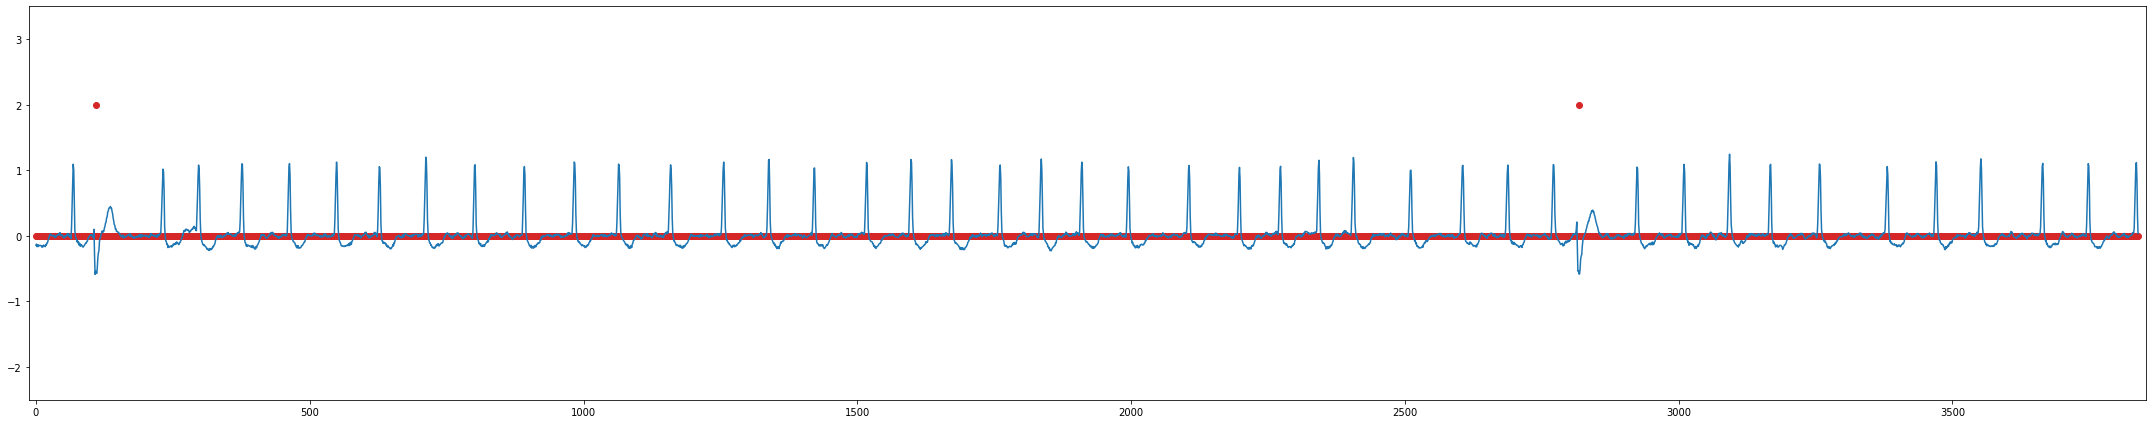

In [ ]:
darr = mega_set[30]

print(len(darr))
dsig = darr[0:S]
dlab = darr[S:]
print(len(dsig),len(dlab))

plt.figure('training set', figsize=(pr_S,6))
plt.ylim(-2.5,3.5)
plt.xlim(-12.8,S+12.8)
plt.plot(dsig)
plt.scatter(np.arange(0,len(dlab)),dlab,color='tab:red')
plt.tight_layout()


## [ choose training set ]

In [ ]:
ls_f = os.listdir(global_dsdir)
print('Available dataset files ['+str(len(ls_f))+']')
for lsf in ls_f:
    print(lsf)
print('--------------------------')

Available dataset files [1]
train_set_1.npy
--------------------------


In [53]:
selected_training_set = 'train_set_1'
mega_set_path = os.path.join(global_dsdir,selected_training_set+'.npy' )
mega_set = np.load(mega_set_path)
print(mega_set.shape)

(178, 7680)


In [ ]:
#<<----------------------------------------------- Get model and Data
model = get_modelFullCNN(True)
data_x = np.expand_dims(mega_set[:,0:S],axis=-1)
data_y = mega_set[:,S:]
print(data_x.shape,data_y.shape)


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 3840, 1)]         0         
_________________________________________________________________
conv1 (Conv1D)               (None, 3838, 32)          128       
_________________________________________________________________
conv2 (Conv1D)               (None, 3836, 32)          3104      
_________________________________________________________________
conv3 (Conv1D)               (None, 3834, 64)          6208      
_________________________________________________________________
conv4 (Conv1D)               (None, 3832, 64)          12352     
_________________________________________________________________
flat5 (Flatten)              (None, 245248)            0         
_________________________________________________________________
dense6 (Dense)               (None, 128)               3139

## [ perform training ]

Epoch 1/2
178/178 [==============================] - 19s 107ms/step - loss: 0.0148 - acc: 0.9991
Epoch 2/2
178/178 [==============================] - 19s 107ms/step - loss: 0.0148 - acc: 0.9991


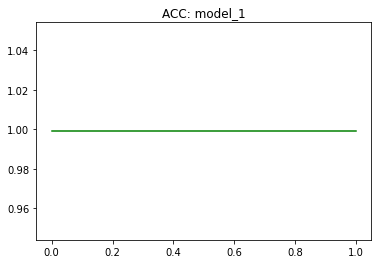

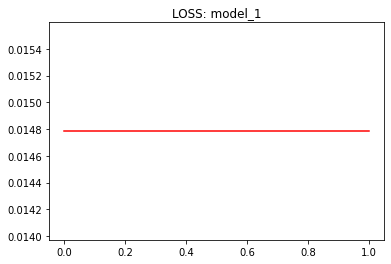

saved model at /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_1.h5
Elapsed time = 0:00:50.189698


In [112]:
timestamp_start = datetime.datetime.now()
#<<----------------------------------------------- Select name for saving weights
ds_model = 'model_1'


#<<----------------------------------------------- Train Model
history = model.fit(
                    data_x, data_y,
                    batch_size=1,
                    epochs=2,
                    #callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

#<<----------------------------------------------- Plot Training params
plt.figure('acc')
plt.title('ACC: '+ds_model)
plt.plot(history.history['acc'],color='green')
plt.show()

plt.figure('Loss')
plt.title('LOSS: '+ds_model)
plt.plot(history.history['loss'],color='red')
plt.show()

#<<----------------------------------------------- Save This model
save_model_name = ds_model +'.h5'        # save model weights to this file
svmpth = os.path.join(global_modeldir, save_model_name)
model.save_weights(svmpth)
print('saved model at '+ str(svmpth))
#-------------------------------------------------------------------------------------------------------

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
(1, 3840, 4)
[1. 1. 1. ... 1. 1. 1.]


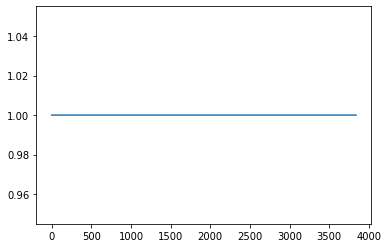

In [111]:
res = model.predict(np.transpose(data_x[0]))
print(res)
print(res.shape)
res1 = res[0,:,0]
print(res1)
plt.plot(res1)